In [1]:
import sys
import nltk
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MultiLabelBinarizer
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')
sys.setrecursionlimit(100000)

## Exploring Job Description Data

In [2]:
data_job_desc = pd.read_csv("data/job_desc.csv")
print(data_job_desc.shape)
data_job_desc.head()

(2000, 4)


,job_title_full,salary,company,user_id
0,Junior Manager Innovation Lab - France (M/F/D),51000.0,g,U1
1,Junior Product Manager - Mobile,70000.0,b,U2
2,Junior Brand Marketing Manager - Mobile (M/F/D),59000.0,g,U3
3,Product Analyst - Pricing & Forecasting (M/F/D),NaN,d,U4
4,Online Marketing Manager,64000.0,h,U5


In [3]:
data_job_desc.nunique()

job_title_full     156
salary              21
company              8
user_id           2000
dtype: int64

In [4]:
len(data_job_desc.job_title_full.unique())

156

In [5]:
data_job_desc.isnull().sum()

job_title_full       0
salary            1387
company              0
user_id              0
dtype: int64

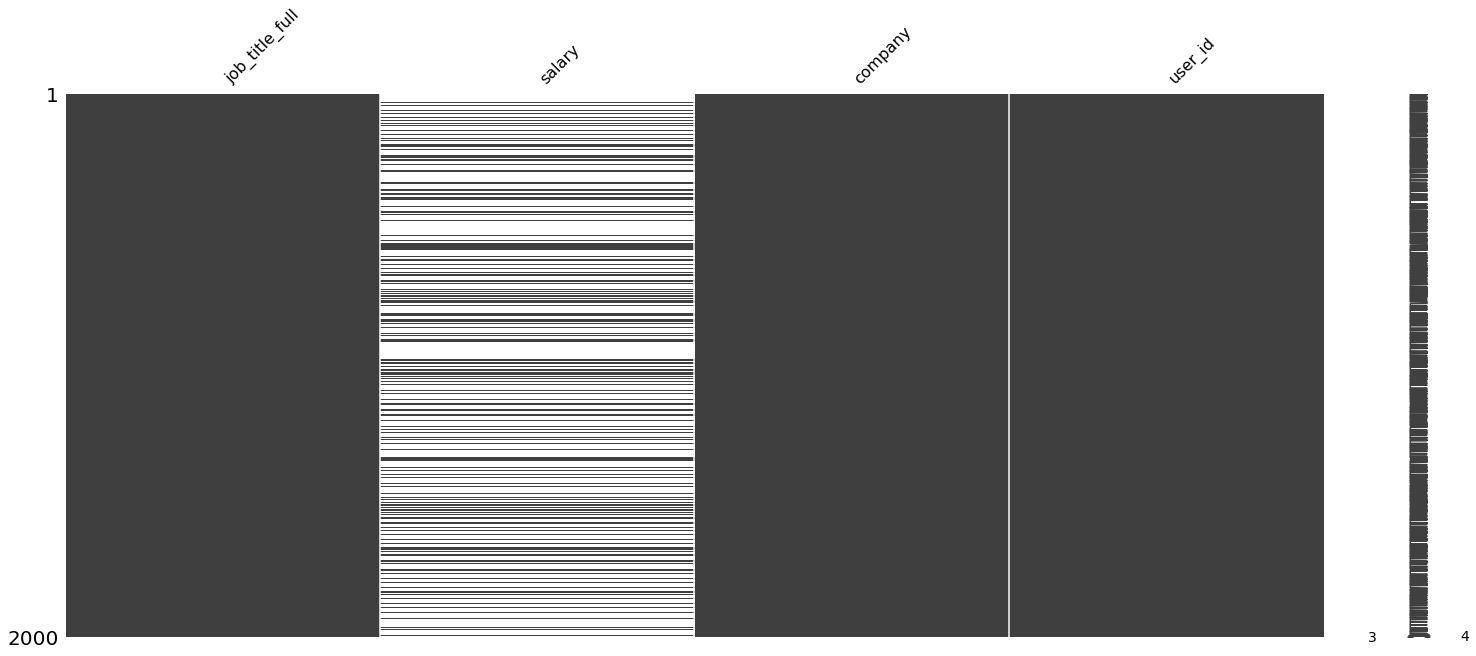

In [6]:
msno.matrix(data_job_desc)

## Exploring User Data

In [7]:
data_user = pd.read_csv("data/user.csv")
print(data_user.shape)
data_user.head()

(2000, 58)


,user_id,has_applied,v1,v10,v11,v12,v13,v14,v15,v16,...,v51,v52,v53,v54,v55,v56,v6,v7,v8,v9
0,U1,1,0.620573,0.018662,0.100803,0.080898,0.420417,0.817681,0.147355,0.446812,...,0.227104,0.811505,0.945988,0.798489,0.148969,0.707921,0.751510,0.349078,0.337132,0.807632
1,U2,1,0.972502,0.870277,0.504887,0.995163,0.179480,0.608719,0.245085,0.851246,...,0.855074,0.683701,0.318416,0.703566,0.400617,0.563469,0.989583,0.073514,0.095885,0.890821
2,U3,1,0.240756,0.546440,0.521399,0.402420,0.640444,NaN,0.184515,0.395058,...,0.614898,0.487564,0.256930,0.653874,0.761972,0.976820,0.264505,0.513135,0.978387,0.620669
3,U4,1,0.004854,0.433188,0.250801,0.242680,0.713586,0.210186,0.977472,0.375024,...,0.407412,0.242282,0.097724,0.191388,0.516972,0.742984,0.232344,0.305115,0.080069,0.297233
4,U5,1,0.835250,0.476812,0.764354,0.449753,0.524924,0.807181,0.294023,0.475043,...,0.605605,0.772735,0.351836,0.932708,0.724384,0.123647,0.091980,0.581444,0.093941,0.612623


In [8]:
data_user.user_id.nunique()

2000

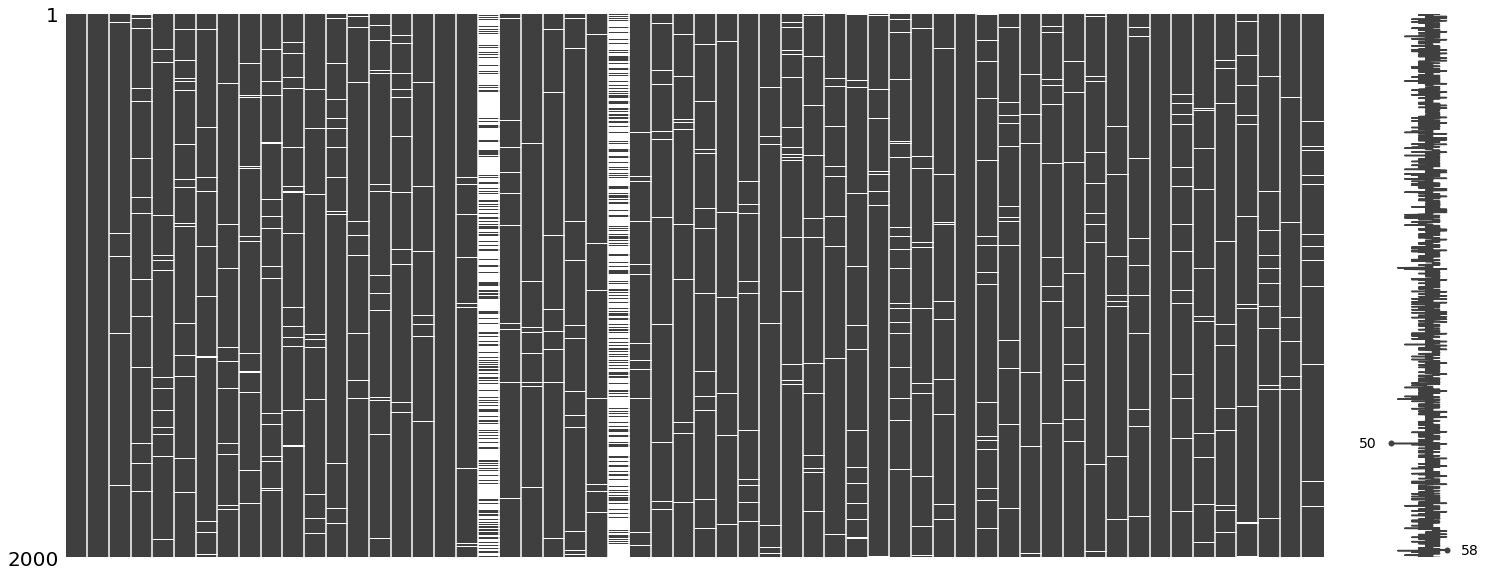

In [9]:
msno.matrix(data_user)

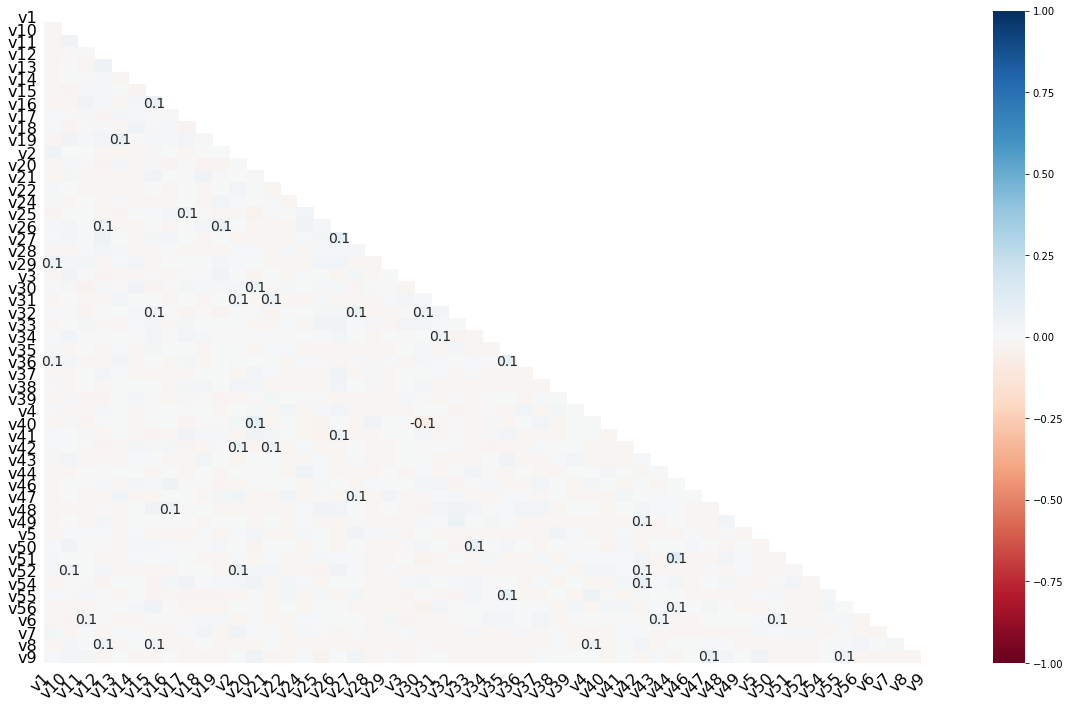

In [10]:
msno.heatmap(data_user)

## Merging & Feature Engineering (User+Job-Description) Data

In [11]:
data = pd.merge(data_job_desc, data_user, on=['user_id'])

In [12]:
data.nunique()

job_title_full     156
salary              21
company              8
user_id           2000
has_applied          2
                  ... 
v56               1959
v6                1953
v7                1973
v8                1964
v9                1960
Length: 61, dtype: int64

### Dropping User column since they are represented by Features

In [13]:
data = data.drop(['user_id'], axis=1)

### Frequency Distribution of Applied/Non-Applied, Salary and Company

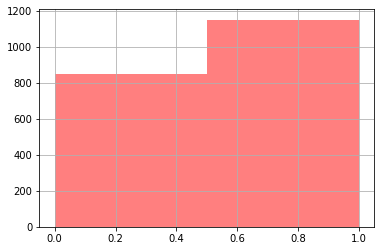

In [14]:
data['has_applied'].hist(bins=len(data.has_applied.unique()), color='red', alpha = 0.5)

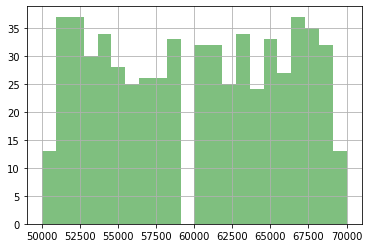

In [15]:
data['salary'].hist(bins=len(data.salary.unique()), color='green', alpha = 0.5)

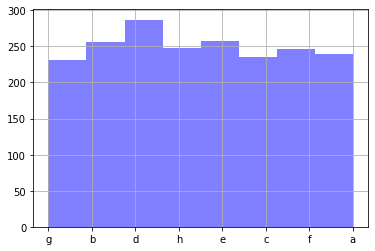

In [16]:
data['company'].hist(bins=len(data.company.unique()), color='blue', alpha = 0.5)

### Correlating Company vs Salary separately for Applied and Not-Applied Jobs.

In [17]:
pos_data = data[data['has_applied']==1]
neg_data = data[data['has_applied']==0]

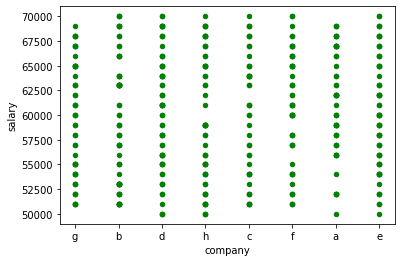

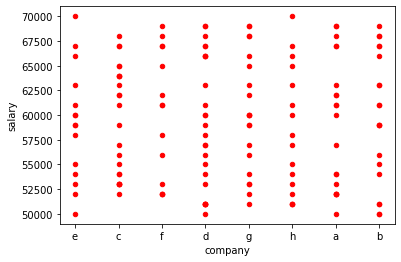

In [18]:
pos_data.plot(kind='scatter',x='company',y='salary',color='green')
neg_data.plot(kind='scatter',x='company',y='salary',color='red')

### Encode Categorical Features: Company

In [19]:
data = pd.get_dummies(data, prefix=['company'], columns =['company'])
data.columns

Index(['job_title_full', 'salary', 'has_applied', 'v1', 'v10', 'v11', 'v12',
       'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v2', 'v20', 'v21',
       'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'v29', 'v3', 'v30',
       'v31', 'v32', 'v33', 'v34', 'v35', 'v36', 'v37', 'v38', 'v39', 'v4',
       'v40', 'v41', 'v42', 'v43', 'v44', 'v45', 'v46', 'v47', 'v48', 'v49',
       'v5', 'v50', 'v51', 'v52', 'v53', 'v54', 'v55', 'v56', 'v6', 'v7', 'v8',
       'v9', 'company_a', 'company_b', 'company_c', 'company_d', 'company_e',
       'company_f', 'company_g', 'company_h'],
      dtype='object')

### Exploring Job Titles

In [20]:
def display_content(freq_map):
        print (top_keyword_freq_map)
        wordcloud = WordCloud(width=1800, height=1600).generate_from_frequencies(freq_map)
        plt.imshow(wordcloud)
        plt.show()
        print("Plotting top 40 contents..")
        nltk.FreqDist(freq_map).plot()

In [21]:
def get_jobtitle_keywords(jobtitle):
    manual_analysis_word_removal_list = ['(m/f/d)', 'mfd', 'team', '-']
    keywords = re.split(',| | &| ;', jobtitle)
    keywords = [re.sub(r'|\.|\(|\)|\]|\[|\/|-|!|\?', '', word) for word in keywords if len(word) > 1]
    keywords = [word.lower() for word in keywords if
                word.lower() not in manual_analysis_word_removal_list]
    keywords = list(set(' '.join(keywords).split()))
    return keywords

{'manager': 984, 'lab': 46, 'junior': 517, 'innovation': 46, 'france': 132, 'product': 242, 'mobile': 122, 'brand': 108, 'marketing': 412, 'analyst': 195, 'forecasting': 80, 'pricing': 197, 'online': 66, 'new': 359, 'ventures': 359, 'growth': 95, 'hacker': 51, 'lead': 481, 'sustainability': 54, 'senior': 511, 'data': 270, 'nlp': 130, 'owner': 46, 'backend': 107, 'learning': 149, 'engineer': 248, 'deep': 97, 'ui': 67, 'designer': 67, 'remote': 336, 'financing': 85, 'supplier': 85, 'consultant': 87, 'seo': 153, 'operations': 43, 'ai': 60, 'researcher': 60, 'machine': 52, 'developer': 99, 'software': 82, 'scientist': 105, 'onboarding': 60, 'apac': 62, 'performance': 47, 'science': 54, 'offline': 49, 'marketeer': 58, 'development': 49, 'business': 49, 'big': 64, 'reserch': 46, 'ux': 55, 'audit': 55, 'internal': 55, 'affairs': 56, 'policy': 56, 'shop': 48, 'transformation': 32, 'global': 32, 'checkout': 36, 'frontend': 51, 'eu': 41, 'culture': 54}


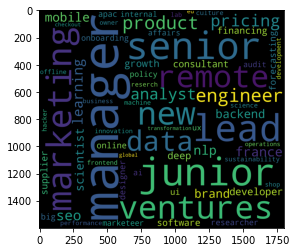

Plotting top 40 contents..


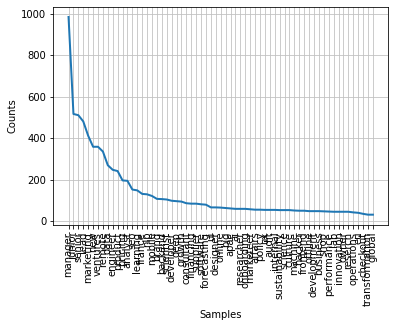

In [22]:
FEATURE_FREQUENCY_THRESHOLD = 0

keyword_freq_map = {}
for index, row in data.iterrows():
    curr_jobtitle = row['job_title_full']
    jobtitle_keywords = get_jobtitle_keywords(curr_jobtitle)

    for keyword in jobtitle_keywords:
        keyword_freq_map[keyword] = keyword_freq_map[keyword] + 1 if keyword in keyword_freq_map else 1

top_keyword_freq_map = dict((k, v) for k, v in keyword_freq_map.items() if v >= FEATURE_FREQUENCY_THRESHOLD)

display_content(top_keyword_freq_map)

In [23]:
job_keywords = list(top_keyword_freq_map.keys())

### Adding fields for Job Title Keywords

In [24]:
data['jobtitle_keywords'] = ''

for index, row in data.iterrows():
    curr_jobtitle = row['job_title_full']
    jobtitle_keywords = get_jobtitle_keywords(curr_jobtitle)
    data['jobtitle_keywords'].values[index] = jobtitle_keywords

data['jobtitle_keywords'].head()

0     [manager, lab, junior, innovation, france]
1             [junior, product, mobile, manager]
2    [mobile, brand, marketing, manager, junior]
3       [analyst, forecasting, product, pricing]
4                   [online, manager, marketing]
Name: jobtitle_keywords, dtype: object

In [25]:
mlb = MultiLabelBinarizer()
data_jobtitle_keywords_encoded = pd.DataFrame(mlb.fit_transform(data['jobtitle_keywords']),
                                              columns='jobtitle_keyword_' + mlb.classes_)
data_jobtitle_keywords_encoded.head(2)

,jobtitle_keyword_affairs,jobtitle_keyword_ai,jobtitle_keyword_analyst,jobtitle_keyword_apac,jobtitle_keyword_audit,jobtitle_keyword_backend,jobtitle_keyword_big,jobtitle_keyword_brand,jobtitle_keyword_business,jobtitle_keyword_checkout,...,jobtitle_keyword_senior,jobtitle_keyword_seo,jobtitle_keyword_shop,jobtitle_keyword_software,jobtitle_keyword_supplier,jobtitle_keyword_sustainability,jobtitle_keyword_transformation,jobtitle_keyword_ui,jobtitle_keyword_ux,jobtitle_keyword_ventures
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
data = data.drop(['jobtitle_keywords'], axis=1)
data = data.drop(['job_title_full'], axis=1)

In [27]:
data = pd.concat([data,data_jobtitle_keywords_encoded], axis = 1)
data.head()

,salary,has_applied,v1,v10,v11,v12,v13,v14,v15,v16,...,jobtitle_keyword_senior,jobtitle_keyword_seo,jobtitle_keyword_shop,jobtitle_keyword_software,jobtitle_keyword_supplier,jobtitle_keyword_sustainability,jobtitle_keyword_transformation,jobtitle_keyword_ui,jobtitle_keyword_ux,jobtitle_keyword_ventures
0,51000.0,1,0.620573,0.018662,0.100803,0.080898,0.420417,0.817681,0.147355,0.446812,...,0,0,0,0,0,0,0,0,0,0
1,70000.0,1,0.972502,0.870277,0.504887,0.995163,0.179480,0.608719,0.245085,0.851246,...,0,0,0,0,0,0,0,0,0,0
2,59000.0,1,0.240756,0.546440,0.521399,0.402420,0.640444,NaN,0.184515,0.395058,...,0,0,0,0,0,0,0,0,0,0
3,NaN,1,0.004854,0.433188,0.250801,0.242680,0.713586,0.210186,0.977472,0.375024,...,0,0,0,0,0,0,0,0,0,0
4,64000.0,1,0.835250,0.476812,0.764354,0.449753,0.524924,0.807181,0.294023,0.475043,...,0,0,0,0,0,0,0,0,0,0


### Filling in NaN values in Salary and Features Columns

In [28]:
data.isnull().sum()

salary                             1387
has_applied                           0
v1                                   27
v10                                  46
v11                                  48
                                   ... 
jobtitle_keyword_sustainability       0
jobtitle_keyword_transformation       0
jobtitle_keyword_ui                   0
jobtitle_keyword_ux                   0
jobtitle_keyword_ventures             0
Length: 129, dtype: int64

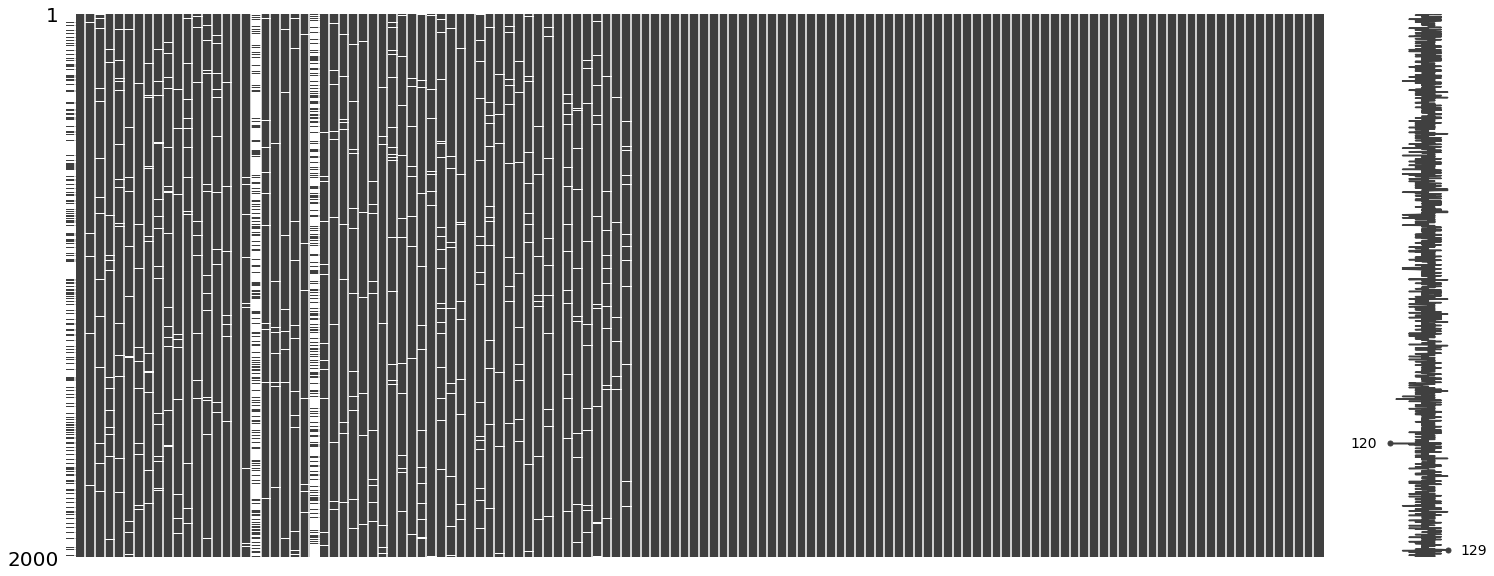

In [29]:
msno.matrix(data)

In [30]:
non_imput_cols = ['has_applied']
data_to_imput = data.drop(non_imput_cols, axis=1)
imput_cols = list(data_to_imput)
non_imputed_data = data.drop(imput_cols, axis=1) 

In [31]:
imp_mean = SimpleImputer(strategy='mean')
imp_mean.fit(data_to_imput)

imp_mean_knn = KNNImputer(n_neighbors=30)

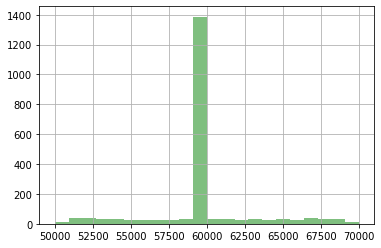

In [32]:
imputed_data = pd.DataFrame(imp_mean.transform(data_to_imput), 
                            columns = imput_cols)

imputed_data['salary'].hist(bins=len(imputed_data.salary.unique()), color='green', alpha = 0.5)

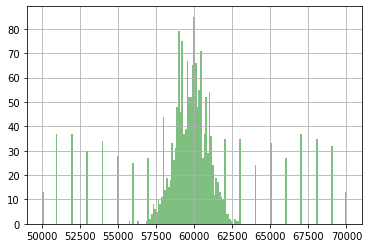

In [33]:
imputed_data = pd.DataFrame(imp_mean_knn.fit_transform(data_to_imput), 
                            columns = imput_cols)

imputed_data['salary'].hist(bins=len(imputed_data.salary.unique()), color='green', alpha = 0.5)

In [34]:
data = pd.concat([non_imputed_data, imputed_data], axis=1, join='inner')

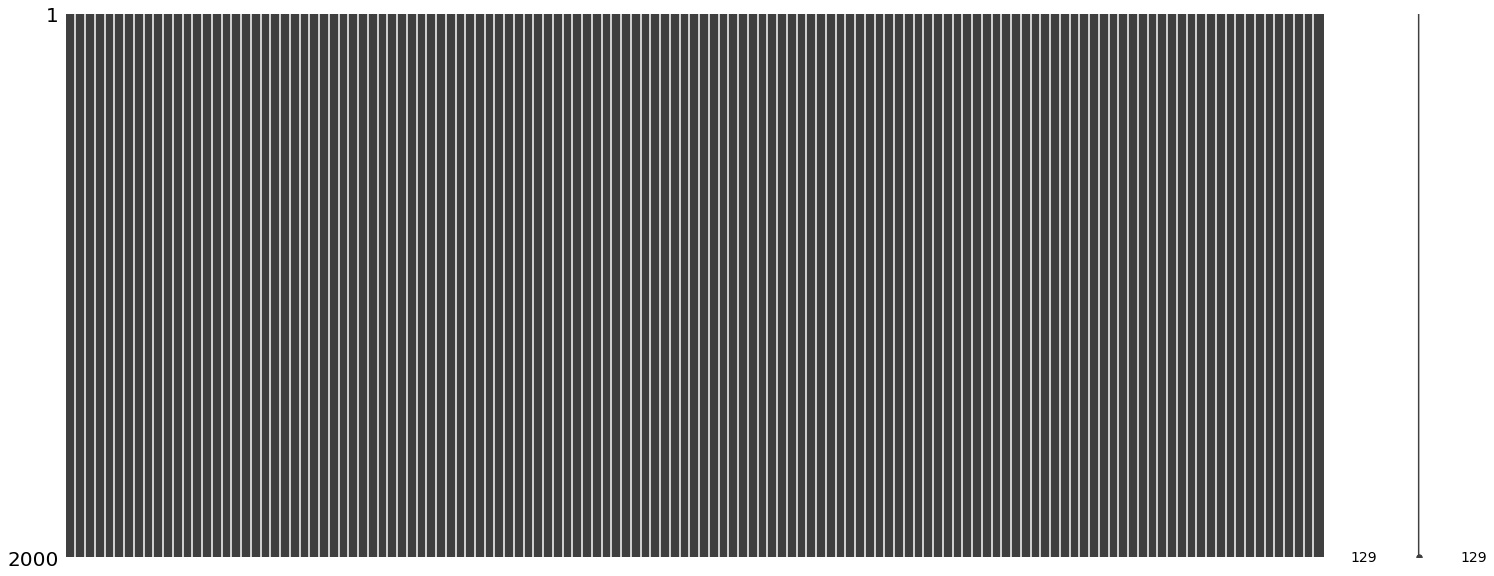

In [35]:
msno.matrix(data)

In [36]:
data.head()

,has_applied,salary,v1,v10,v11,v12,v13,v14,v15,v16,...,jobtitle_keyword_senior,jobtitle_keyword_seo,jobtitle_keyword_shop,jobtitle_keyword_software,jobtitle_keyword_supplier,jobtitle_keyword_sustainability,jobtitle_keyword_transformation,jobtitle_keyword_ui,jobtitle_keyword_ux,jobtitle_keyword_ventures
0,1,51000.0,0.620573,0.018662,0.100803,0.080898,0.420417,0.817681,0.147355,0.446812,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,70000.0,0.972502,0.870277,0.504887,0.995163,0.179480,0.608719,0.245085,0.851246,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,59000.0,0.240756,0.546440,0.521399,0.402420,0.640444,0.400145,0.184515,0.395058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,58200.0,0.004854,0.433188,0.250801,0.242680,0.713586,0.210186,0.977472,0.375024,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,64000.0,0.835250,0.476812,0.764354,0.449753,0.524924,0.807181,0.294023,0.475043,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
